In [6]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.express as px
from IPython.display import display, clear_output
import time
import os
import datetime
import joblib


In [7]:
model_path = 'nn-models/nn_model.keras'

try:
    loaded_model = tf.keras.models.load_model(model_path)
    print("model loaded")
    loaded_model.summary()
except Exception as e:
    print(f"model loaded failed: {e}")

scaler_path = 'nn-models/scaler.pkl'

try:
    scaler = joblib.load(scaler_path)
    print("scaler loaded")
except Exception as e:
    print(f"scaler loaded failed: {e}")


model loaded


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 779 (3.05 KB)

 Trainable params: 259 (1.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 520 (2.04 KB)

scaler loaded


In [8]:
class Car:

    def __init__(self,car_id,init_s=0.0,init_v=0.0):
        self.id = car_id
        self.s = init_s
        self.init_s = init_s
        # displacement, save itit value for rest
        
        self.v = init_v
        self.init_v = init_v
        # velocity, save itit value for rest
        
        self.a = 0.0 
        # acceleration

        self.s_history = [self.s]
        self.v_history = [self.v]
        self.a_history = [self.a]
        # arreys to save data
    
    def reset(self):
        self.s = self.init_s
        self.v = self.init_v
        self.a = 0.0
     
        self.s_history = [self.s]
        self.v_history = [self.v]
        self.a_history = [0.0]
        # reset to initial values
        
    def set_a(self, a):
        self.a = a
        # get acceleration
        """
        accel is the system input of the auto car project
        the accel of ego car will be defined by NN
        the accels of others car will be generate by some defined rule
        for example, randomly
        """

    def step(self, dt):
        self.s += self.v*dt+0.5*self.a*dt*dt
        self.v += dt*self.a

        self.s_history.append(self.s)
        self.v_history.append(self.v)
        self.a_history.append(self.a)
        """ 
        save all history of displacement (s) and velocity (v) 
        into the arrey self.s_history and self.v_history
        """
        
        

In [9]:
class PID_controller:
    
    """
    This is a very simple PID control logic
    """
    def __init__(self,Kp,Ki,Kd,dt):
        """
        This is the PID init
        Kp for proportional gain
        Ki for Integral gain
        Kd for Dericative gain
        dt for the time inerval
        err_integral is the add up err from the begaining
        err_previous is the err from the previous time step
        """
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.err_integral = 0.0
        self.err_previous = 0.0
        self.output_history = [0.0]
        self.err_history = [0.0]

    def step(self,err):
        
        # P control
        p_out = self.Kp*err

        # I control
        i_out = self.Ki*self.err_integral
        # update the addup err
        self.err_integral += err*dt 

        # D control
        d_out = self.Kd*((err-self.err_previous)/self.dt)
        # record current err for next time step 
        # will become previous err in next time step
        self.err_previous = err

        control_output = p_out + i_out + d_out
        self.output_history.append(control_output)
        self.err_history.append(err)
        return control_output

    def reset(self):

        # init the controller status before using
        self.err_integral = 0.0
        self.err_previous = 0.0
        self.output_history = [0.0]
        self.err_history = [0.0]
        

In [23]:
"""
Test and compare the NN controller and PID controller
"""

np.random.seed()

random_gap = np.random.uniform(30,40)
random_v = np.random.uniform(15,20)

ego_car = Car(car_id="ego",init_s=0.0,init_v=random_v)
nn_car = Car(car_id="nn",init_s=0.0,init_v=random_v)
#generate ego car at initial point with random velocity

front_car = Car(car_id="front",init_s=2*random_gap,init_v=random_v)
back_car = Car(car_id="back",init_s=-random_gap,init_v=random_v)
#generate the front car and the back car as well

cars = [ego_car, front_car, back_car, nn_car]

print(f"New cars are created!")
print(f"The ego car is at {ego_car.s} m, with v={ego_car.v} m/s and a={ego_car.a} m/s^2")
print(f"The NN car is at {nn_car.s} m, with v={nn_car.v} m/s and a={nn_car.a} m/s^2")
print(f"The front car is at {front_car.s} m, with v={front_car.v} m/s and a={front_car.a} m/s^2")
print(f"The back car is at {back_car.s} m, with v={back_car.v} m/s and a={back_car.a} m/s^2")


simulation_time = 100.0
dt = 0.1

# set ego car accel
a_set_random = 0.0
# set random accel for front and back car
a_set_random_max = 5.0
# using a_set_random_max to limit the amplitude

a_set_max = 3.0
# Max accel for ego car (speed up)
a_set_min = -5.0
# Min accel for ego car (break)

d_diff = 0.0 
# also considered d_diff as error for the controller

Kp = 0.085
Ki = 0.00002955
Kd = 0.070
# select control params, better not change any of them

a_accept = 1.0
"""
if the accel chosen the by the controller 
within the range of [-a_accept,a_accept]
the ego car won't take any action
"""


ego_controller = PID_controller(Kp,Ki,Kd,dt)
nn_controller = PID_controller(Kp,Ki,Kd,dt)
controllers = [ego_controller,nn_controller]


d_2_front_old = [2*random_gap]
d_2_back_old = [random_gap]
v_2_front_old = [0.0]
v_2_back_old = [0.0]

d_2_front = [2*random_gap]
d_2_back = [random_gap]
v_2_front = [0.0]
v_2_back = [0.0]

for car in cars:
    car.reset()
# for controller in controllers:
nn_controller.reset()
ego_controller.reset()

time_steps = np.arange(0.0,simulation_time,dt)

print(f"Simulating...")
for k in range(len(time_steps)):
    
    """
    old ego car dynamic: 
    if closer to front -> break
    if in the middle -> stay
    if closer to back -> speed up
    """
    d_diff = d_2_front_old[-1]-d_2_back_old[-1]
    a_set = ego_controller.step(d_diff)
    
    if a_set <= -a_accept:
        a_set = a_set_min
    elif a_set >= a_accept:
        a_set = a_set_max
    else:
        a_set = 0.0
    
    ego_car.set_a(a_set)

    # new ego car (nn_car) dynamic
    current_features = np.array([[
        d_2_front[-1],
        d_2_back[-1],
        v_2_front[-1],
        v_2_back[-1]
    ]])

    scaled_features = scaler.transform(current_features)
    prediction = loaded_model.predict(scaled_features, verbose=0)
    action_class = np.argmax(prediction, axis=1)[0]

    ACTION_MAP = {
        0: a_set_min,   # slow down
        1: 0.0,         # stay
        2: a_set_max    # speed up
    }
    a_nn = ACTION_MAP[action_class]
    nn_car.set_a(a_nn)

    d_diff = d_2_front[-1]-d_2_back[-1]
    a_nn = nn_controller.step(d_diff)

    """
    front car and back car dynamic:
    randomly select acceleration
    """
    np.random.seed()
    a_set_random = np.random.uniform(-a_set_random_max,a_set_random_max)
    front_car.set_a(a_set_random)
    back_car.set_a(a_set_random)
    
    ego_car.step(dt)
    nn_car.step(dt)
    front_car.step(dt)
    back_car.step(dt)

    # update features
    d_2_front_old.append(front_car.s-ego_car.s)
    d_2_back_old.append(ego_car.s-back_car.s)
    v_2_front_old.append(front_car.v-ego_car.v)
    v_2_back_old.append(ego_car.v-back_car.v)

    d_2_front.append(front_car.s-nn_car.s)
    d_2_back.append(nn_car.s-back_car.s)
    v_2_front.append(front_car.v-nn_car.v)
    v_2_back.append(nn_car.v-back_car.v)

    if d_2_front_old[-1]<=0 or d_2_back_old[-1]<=0 or d_2_front[-1]<=0 or d_2_back[-1]<=0:
        print("Here's a car crash!!! ")
        break

print(f"Simulation finished.")

New cars are created!
The ego car is at 0.0 m, with v=15.344352539172698 m/s and a=0.0 m/s^2
The NN car is at 0.0 m, with v=15.344352539172698 m/s and a=0.0 m/s^2
The front car is at 63.37309581749898 m, with v=15.344352539172698 m/s and a=0.0 m/s^2
The back car is at -31.68654790874949 m, with v=15.344352539172698 m/s and a=0.0 m/s^2
Simulating...
Simulation finished.


In [24]:
# %matplotlib widget

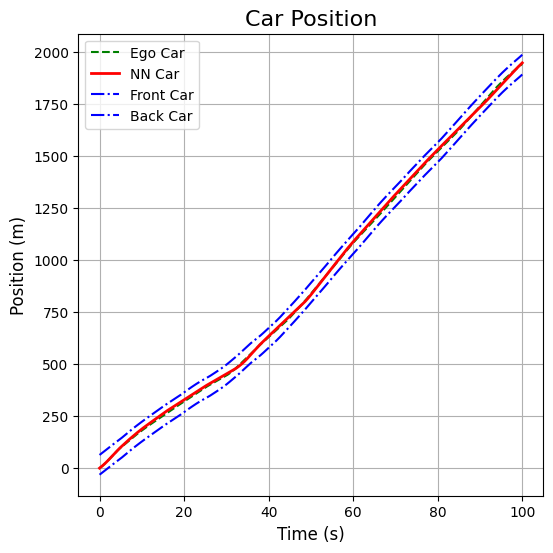

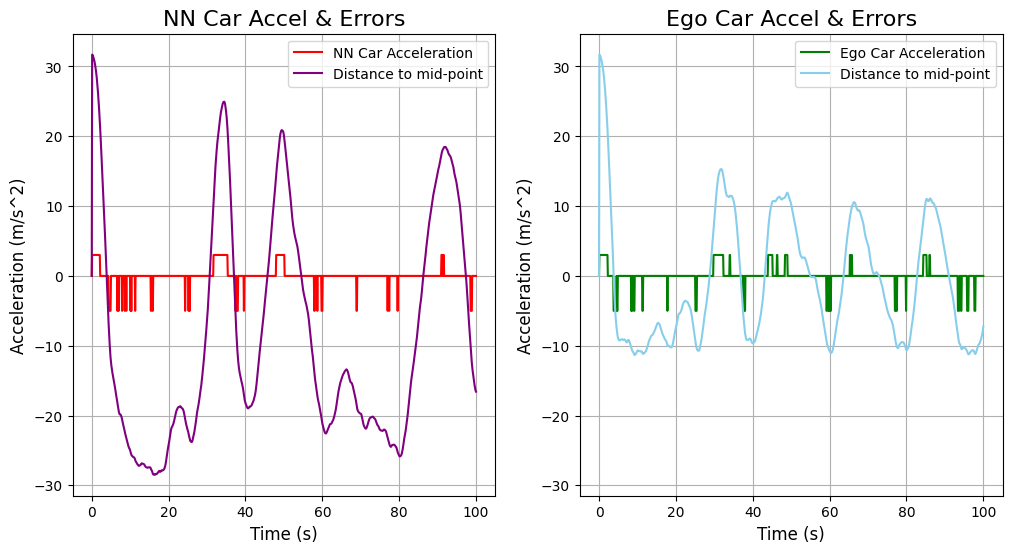

In [26]:


plot_time_axis = np.arange(len(ego_car.s_history))*dt

fig, ax1 = plt.subplots(figsize=(6,6))

ax1.set_title('Car Position', fontsize=16)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Position (m)', fontsize=12)
ax1.plot(plot_time_axis, ego_car.s_history, label='Ego Car', color='green', linestyle='--')
ax1.plot(plot_time_axis, nn_car.s_history, label='NN Car', color='red', linewidth=2)
ax1.plot(plot_time_axis, front_car.s_history, label='Front Car', color='blue', linestyle='-.')
ax1.plot(plot_time_axis, back_car.s_history, label='Back Car', color='blue', linestyle='-.')
ax1.legend()
ax1.grid(True)

fig, [ax2,ax3] = plt.subplots(1, 2, figsize=(12,6))
ax2.set_title('NN Car Accel & Errors', fontsize=16)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Acceleration (m/s^2)', fontsize=12)
ax2.plot(plot_time_axis, nn_car.a_history, label='NN Car Acceleration', color='red')
ax2.plot(plot_time_axis, nn_controller.err_history, label='Distance to mid-point', color='purple',linestyle='-')
ax2.legend()
ax2.grid(True)

ax3.set_title('Ego Car Accel & Errors', fontsize=16)
ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel('Acceleration (m/s^2)', fontsize=12)
ax3.sharey(ax2)
ax3.plot(plot_time_axis, ego_car.a_history, label='Ego Car Acceleration', color='green')
ax3.plot(plot_time_axis, ego_controller.err_history, label='Distance to mid-point', color='skyblue',linestyle='-')
ax3.legend()
ax3.grid(True)
plt.show() 